In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import polars as pl

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

# Choose sample and chrom

In [5]:
focal_sample_id = "PD50489e"
t2t_chrom = "chr2"
denovo_chrom = t2t_chrom + "_RagTag"



# Test pipeline manually

In [6]:
# %%time
# events_df = pl.scan_parquet(
#     f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{denovo_chrom}.read_refinement.parquet",
# )

# events_df = diagnostics.filter_read_refinements(events_df)
# snps_df = diagnostics.extract_snps(events_df)

# snps_df = snps_df.collect(streaming=True)

In [7]:
# %%time
# #
# # Phasing coverage
# #
# hap_and_certainty_to_bedgraph = {}
# for hap in [1,2]:
#     for certainty in [0.95]: 
#         hap_and_certainty_to_bedgraph[(hap, certainty)] = \
#             str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
#                 / f"{focal_sample_id}" / f"{focal_sample_id}.{denovo_chrom}.hap{hap}.minimap2.sorted.primary_alignments.hifiasm_haplotagged_{certainty}.coverage.bedgraph")

# annotated_snps_df = diagnostics.add_phasing_coverage_annotation(
#     snps_df,
#     hap_and_certainty_to_bedgraph
# )

# #
# # TRF
# #
# annotated_snps_df = diagnostics.add_tandem_repeat_finder_annotation(
#     annotated_snps_df,
#     f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/05.ragtag/03.haplotype_specific_scaffolds/{focal_sample_id}/haplotype_1/ragtag.scaffold.fasta.{denovo_chrom}.trf.dat",
#     f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/05.ragtag/03.haplotype_specific_scaffolds/{focal_sample_id}/haplotype_2/ragtag.scaffold.fasta.{denovo_chrom}.trf.dat",
# )

# #
# # sdust
# #
# annotated_snps_df = diagnostics.add_sdust_annotation(
#     annotated_snps_df,
#     f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/05.ragtag/03.haplotype_specific_scaffolds/{focal_sample_id}/haplotype_1/ragtag.scaffold.fasta.{denovo_chrom}.sdust.tsv",
#     f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/05.ragtag/03.haplotype_specific_scaffolds/{focal_sample_id}/haplotype_2/ragtag.scaffold.fasta.{denovo_chrom}.sdust.tsv",
# )


# annotated_snps_df = annotated_snps_df.collect(streaming=True)

## Some summary stats

In [8]:
# (annotated_snps_df
#     .filter(pl.col("is_high_conf_snp") == 1)
#     .select(
#         ((pl.col("hap1_certainty_0.95_coverage") >= 3) & (pl.col("hap2_certainty_0.95_coverage") >= 3)).alias("is_phased_covered"),
#         ((pl.col("trf_repeat_length_hap1") == 0) & (pl.col("trf_repeat_length_hap2") == 0)).alias("is_not_trf"),
#         ((pl.col("sdust_repeat_length_hap1") == 0) & (pl.col("sdust_repeat_length_hap2") == 0)).alias("is_not_sdust"),
#         ((pl.col("qual_start1") == 93) & (pl.col("qual_start2") == 93)).alias("good_bq"),
#     )
#     .group_by(["is_phased_covered", "is_not_trf", "is_not_sdust", "good_bq"])
#     .count()
#     .sort(by="count", descending=True)
# )

In [9]:
# hap_stats_df = diagnostics.snps_to_read_stats(
#     annotated_snps_df,
#     (
#             pl.col("is_high_conf_snp") & \
#             ((pl.col("hap1_certainty_0.95_coverage") >= 3) & (pl.col("hap2_certainty_0.95_coverage") >= 3)) & \
#             ((pl.col("trf_repeat_length_hap1") == 0) & (pl.col("trf_repeat_length_hap2") == 0)) & \
#             ((pl.col("sdust_repeat_length_hap1") == 0) & (pl.col("sdust_repeat_length_hap2") == 0)) & 
#             ((pl.col("qual_start1") == 93) & (pl.col("qual_start2") == 93))
#     ),
#     "frac_fits1_super_conf",    
# )

In [10]:
# with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
#     display(
#         hap_stats_df.filter(~((pl.col("frac_fits1_super_conf") == 0) | (pl.col("frac_fits1_super_conf") == 1)))
#         [:10]
#     )
    



# Analyze read

In [11]:
# focal_read = "m64094e_220715_151527/70976535/ccs"

In [12]:
# with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
#     display(annotated_snps_df
#         .drop(["is_forward1", "is_forward2", "read_length1", "read_length2", "mapq1", "mapq2"])
#         .filter(pl.col("read_name") == focal_read)
#         .filter(pl.col("op1").ne_missing(pl.col("op2")))
#         .filter(pl.col("is_high_conf_snp") == 1)
#     )
    

# SNP analysis

In [13]:
%%time
events_df = pl.scan_parquet(
    Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.read_refinement.parquet"
)

candidates_df = pl.read_parquet(
    Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_0.95.candidate_reads.parquet"
)

high_conf_snps_df = pl.read_parquet(
    Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_0.95.snps.parquet"
)

CPU times: user 1.75 s, sys: 1.34 s, total: 3.09 s
Wall time: 6.85 s


## BQ

### General distribution (the first bp of all events)

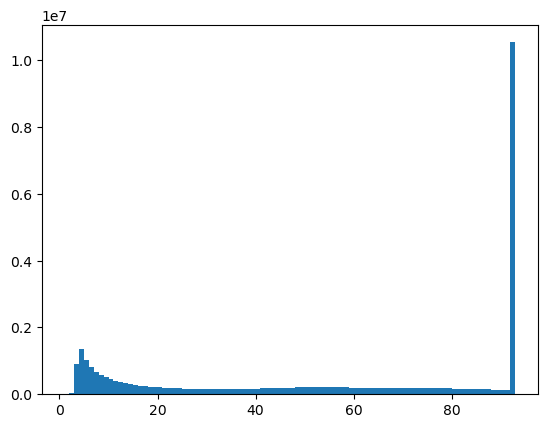

In [14]:
plt.hist(
    (events_df
        .select(pl.col("qual_start1"))
        .collect()
    ), 
    bins=np.arange(1,94)
);

### Distribution of high conf SNPs

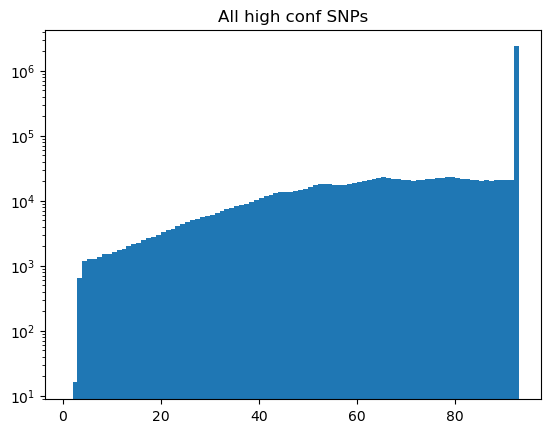

In [15]:
plt.hist(
    (high_conf_snps_df
        .select(pl.col("qual_start1"))
    ), 
    bins=np.arange(1,94),
    log=True
);
plt.title("All high conf SNPs");

In [16]:
high_conf_snps_df.shape

(3525011, 35)

In [17]:
high_conf_snps_df.head()

start,end,length,op1,op2,ref1_start,ref1_end,ref1_gap,ref2_start,ref2_end,ref2_gap,cigar_ptr1,cigar_ptr2,read_name,is_forward1,is_forward2,read_length1,read_length2,mapq1,mapq2,qual_start1,qual_start2,total_mismatches,is_snp,is_high_conf_snp,fits1_more,trf_repeat_length_hap1,trf_n_copies_hap1,trf_repeat_length_hap2,trf_n_copies_hap2,sdust_repeat_length_hap1,sdust_repeat_length_hap2,hap1_certainty_0.95_coverage,hap2_certainty_0.95_coverage,is_high_quality_snp
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,bool,bool,i32,i32,i32,i32,u8,u8,i64,bool,bool,i32,i64,f64,i64,f64,i32,i32,i64,i64,bool
6472,6473,1,8,7,17059415,17059416,1,16572032,16572033,1,53,50,"""m64094e_220717…",true,true,19493,19493,60,60,63,63,6,true,true,0,0,0.0,0,0.0,0,0,17,13,true
7461,7462,1,8,7,17060417,17060418,1,16573023,16573024,1,69,62,"""m64094e_220717…",true,true,19493,19493,60,60,63,63,6,true,true,0,0,0.0,0,0.0,0,0,20,12,true
7914,7915,1,8,7,17060871,17060872,1,16573477,16573478,1,79,68,"""m64094e_220717…",true,true,19493,19493,60,60,54,54,6,true,false,0,0,0.0,0,0.0,0,0,0,0,false
8735,8736,1,8,7,17061696,17061697,1,16574301,16574302,1,93,78,"""m64094e_220717…",true,true,19493,19493,60,60,45,45,6,true,false,0,0,0.0,0,0.0,0,0,0,0,false
8918,8919,1,8,7,17061879,17061880,1,16574484,16574485,1,95,78,"""m64094e_220717…",true,true,19493,19493,60,60,63,63,6,true,true,0,0,0.0,0,0.0,0,0,21,12,true


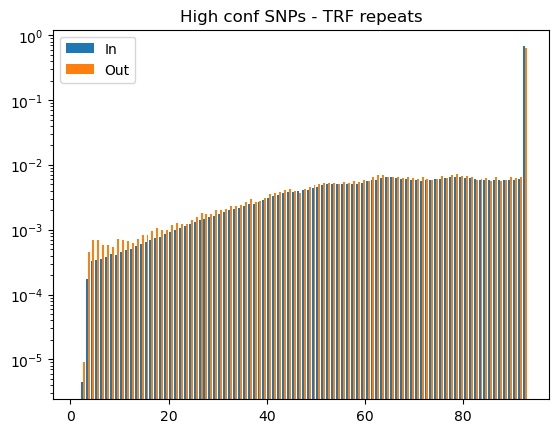

In [18]:
plt.hist(
    [
        (high_conf_snps_df
            .filter((pl.col("trf_repeat_length_hap1") == 0) & (pl.col("trf_repeat_length_hap2") == 0))
            .select(pl.col("qual_start1"))
        )["qual_start1"],
        (high_conf_snps_df
            .filter((pl.col("trf_repeat_length_hap1") > 0) | (pl.col("trf_repeat_length_hap2") > 0))
            .select(pl.col("qual_start1"))
        )["qual_start1"], 
    ],
    bins=np.arange(1,94),
    log=True,
    density=True,
);
plt.title("High conf SNPs - TRF repeats");
plt.legend(["In", "Out"]);

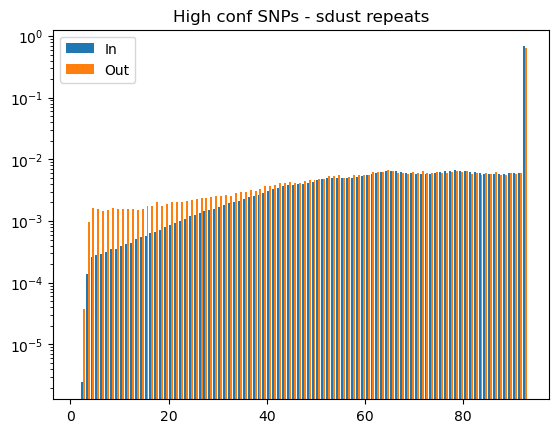

In [19]:
plt.hist(
    [
        (high_conf_snps_df
            .filter((pl.col("sdust_repeat_length_hap1") == 0) & (pl.col("sdust_repeat_length_hap2") == 0))
            .select(pl.col("qual_start1"))
        )["qual_start1"],
        (high_conf_snps_df
            .filter((pl.col("sdust_repeat_length_hap1") > 0) | (pl.col("sdust_repeat_length_hap2") > 0))
            .select(pl.col("qual_start1"))
        )["qual_start1"], 
    ],
    bins=np.arange(1,94),
    log=True,
    density=True,
);
plt.title("High conf SNPs - sdust repeats");
plt.legend(["In", "Out"]);

### Look at some examples to decide a threshold (select read and SNP here, check on dashboard)

In [20]:
# plt.hist(
#     (cand_snps_df
#         .select(pl.col("qual_start1"))
#     ), 
#     bins=np.arange(1,94),
#     log=True
# );


In [21]:
# with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
#     display(cand_snps_df
#         .filter(pl.col("qual_start1") < 20)
#     )

## Calibrate BQ based on alleles

## Repeats

In [22]:
snp_stats_df = (high_conf_snps_df
    .filter(pl.col("is_high_conf_snp") == 1)
    .select(
        ((pl.col("hap1_certainty_0.95_coverage") >= 3) & (pl.col("hap2_certainty_0.95_coverage") >= 3)).alias("is_phased_covered"),
        ((pl.col("trf_repeat_length_hap1") == 0) & (pl.col("trf_repeat_length_hap2") == 0)).alias("is_not_trf"),
        ((pl.col("sdust_repeat_length_hap1") == 0) & (pl.col("sdust_repeat_length_hap2") == 0)).alias("is_not_sdust"),
        ((pl.col("qual_start1") >= 60) & (pl.col("qual_start2") >= 60)).alias("good_bq"),
    )
    .group_by(["is_phased_covered", "is_not_trf", "is_not_sdust", "good_bq"])
    .count()
    .sort(by="count", descending=True)
)

display(snp_stats_df)

is_phased_covered,is_not_trf,is_not_sdust,good_bq,count
bool,bool,bool,bool,u32
true,true,true,true,2834461
false,true,true,true,7162


In [23]:
cols = ["is_phased_covered"]
df = snp_stats_df.select(cols + ["count"]).group_by(cols).sum().sort(by="count", descending=True)
df = df.with_columns((df["count"] / df["count"].sum()).alias("frac"))
display(df)


is_phased_covered,count,frac
bool,u32,f64
true,2834461,0.99748
false,7162,0.00252


# Noisy reads

In [24]:
noise_df = (events_df
    .filter((pl.col("op1") == 8) & (pl.col("op2") == 8) & (pl.col("length") == 1))
    .group_by("read_name")
    .agg(
        pl.col("length").sum(),
        pl.col("read_length1").mean(),
    )
).collect()

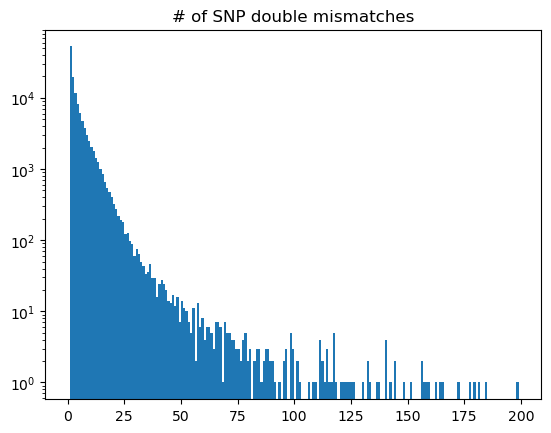

In [25]:
plt.hist(noise_df["length"], bins=np.arange(200), log=True, density=False);
plt.title("# of SNP double mismatches");

In [26]:
events_df.unique("read_name").collect().shape

(493460, 22)

In [27]:
noise_df.shape

(125341, 3)

In [28]:
(493446 - 124696) / 493446

0.7472955500703218

In [29]:
(noise_df.filter(pl.col("length") > 10)).shape

(10945, 3)

In [30]:
(493446 - 10957) / 493446

0.9777949360213681

In [31]:
(noise_df.filter(pl.col("length") > 30)).shape

(809, 3)

In [32]:
(493446 - 812) / 493446

0.9983544298666926

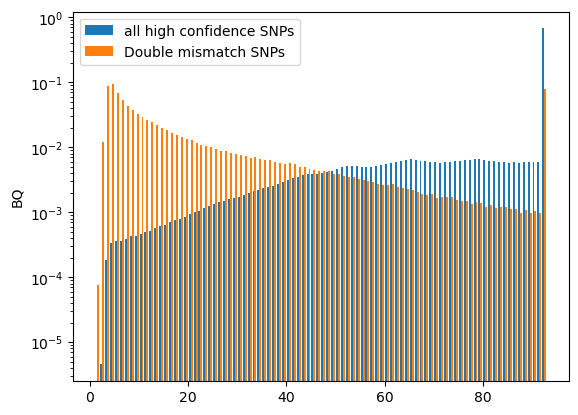

In [33]:
plt.hist(
    [
        (high_conf_snps_df.select(pl.col("qual_start1")))["qual_start1"],
        (events_df
            .filter((pl.col("op1") == 8) & (pl.col("op2") == 8) & (pl.col("length") == 1))
            .select("qual_start1")
        ).collect()["qual_start1"]
    ], 
    bins=np.arange(1,94),
    log=True, 
    density=True,
);

plt.legend(["all high confidence SNPs", "Double mismatch SNPs"])
plt.ylabel("BQ");


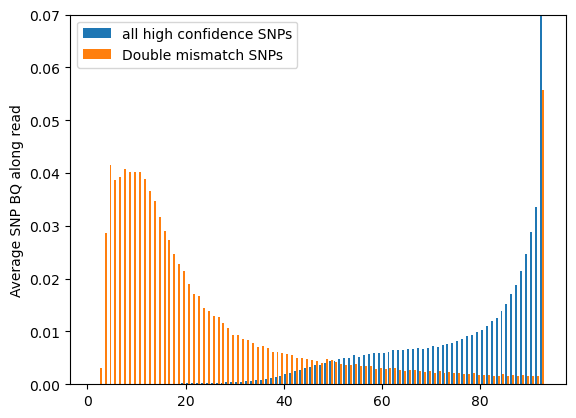

In [34]:
plt.hist(
    [
        (high_conf_snps_df
            .group_by("read_name")
            .agg(pl.col("qual_start1").mean())            
        )["qual_start1"],
        (events_df
            .filter((pl.col("op1") == 8) & (pl.col("op2") == 8) & (pl.col("length") == 1))
            .group_by("read_name")
            .agg(pl.col("qual_start1").mean())
        ).collect()["qual_start1"]
    ], 
    bins=np.arange(1,94),
    log=False, 
    density=True,
);

plt.legend(["all high confidence SNPs", "Double mismatch SNPs"])
plt.ylabel("Average SNP BQ along read");
plt.ylim(0,0.07);

In [35]:
noise_df

read_name,length,read_length1
str,i64,f64
"""m64174e_220620…",1,3536.0
"""m64094e_220715…",1,11148.0
"""m64094e_220715…",6,18377.0
"""m64174e_220620…",5,4651.0
"""m64174e_220620…",1,14735.0
"""m64094e_220715…",1,17961.0
"""m64094e_220717…",1,10953.0
"""m64174e_220620…",1,11141.0
"""m64174e_220620…",3,12026.0


In [36]:
events_df_with_mismatches = (events_df
    .join(
        (events_df
            .filter((pl.col("op1") == 8) & (pl.col("op2") == 8) & (pl.col("length") == 1))
            .group_by("read_name")
            .agg(
                pl.col("length").sum().alias("total_mismatches"),
            )
        ),
        on="read_name",
        how="left",
    )
    .fill_null(0)
).collect()

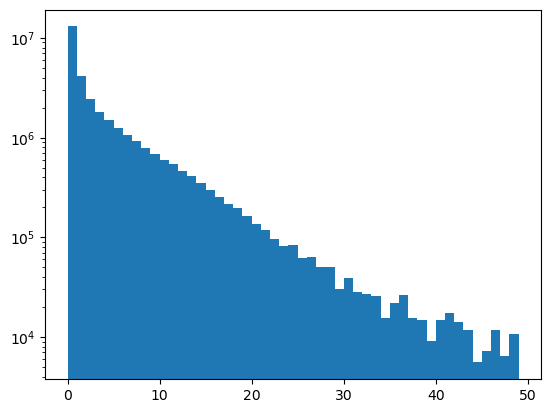

In [37]:
plt.hist(events_df_with_mismatches["total_mismatches"], bins=np.arange(0,50), log=True);

# Analyze common transitions

In [38]:
cand_snps_df = (high_conf_snps_df
    .join(candidates_df, on="read_name")
    .filter("is_high_quality_snp")
    .sort(by=["read_name", "start"])
)

nzi = np.nonzero((np.diff(cand_snps_df["fits1_more"])!=0) & (cand_snps_df["read_name"][:-1] == cand_snps_df["read_name"][1:]).to_numpy())[0]

In [39]:
common_trans_df = (
    pl.DataFrame({
        "first_hap1": cand_snps_df[nzi]["ref1_start"], 
        "second_hap1": cand_snps_df[nzi+1]["ref1_start"],
        "first_hap2": cand_snps_df[nzi]["ref2_start"], 
        "second_hap2": cand_snps_df[nzi+1]["ref2_start"],
    })
    .group_by(["first_hap1", "second_hap1", "first_hap2", "second_hap2"])
    .count()
    .sort(by="count", descending=True)
    .filter(pl.col("count") > 1)
)

common_trans_df

first_hap1,second_hap1,first_hap2,second_hap2,count
i64,i64,i64,i64,u32
97315334,97321892,97724090,97730648,6
89089998,89098810,87901425,87910227,4
111681699,111689770,112327207,112335262,3
219921960,219924090,219514105,219516234,3
182529501,182538333,182326072,182334836,3
136902451,136910266,136810067,136817879,3
233205286,233213123,232617205,232625060,3
125522005,125530068,126166336,126174399,3
130255093,130271408,130686690,130703005,2


In [40]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
    display(
        (cand_snps_df
            .filter(pl.col("ref1_start") == 99105669)
        )["read_name"]
    )

read_name
str


# Compare COs with Sangjin's results?

## Loading files using T2T as reference

In [41]:
t2t_hapfusion_output_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/03.T2T-CHM13")

def t2t_load_files(sample_id):
    data_path = t2t_hapfusion_output_path / sample_id

    reads_df = pd.read_csv(
        str(data_path / f"chm13.{sample_id}.hapfusion.txt"),
        comment="#",
        delim_whitespace=True,
        header=None,
    )

    log_df = pd.read_csv(
        str(data_path / "hapfusion.log"),
        delim_whitespace=True,
        index_col=0,
    )

    candidates_df = pd.read_csv(
        str(data_path / "hapfusion_candidates.txt"),
        delim_whitespace=True,
    )

    return {"reads": reads_df, "summary": log_df, "candidates": candidates_df}



## Loading files using de-novo assembly as reference

In [42]:
denovo_hapfusion_output_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")

def denovo_load_files(sample_id):
    data_path = denovo_hapfusion_output_path / sample_id
    if not (data_path / f"{sample_id}.hapfusion.txt").exists():
        data_path = denovo_hapfusion_output_path / sample_id / sample_id

    reads_df = pd.read_csv(
        str(data_path / f"{sample_id}.hapfusion.txt"),
        comment="#",
        delim_whitespace=True,
        header=None,
    )

    log_df = pd.read_csv(
        str(data_path / "hapfusion.log"),
        delim_whitespace=True,
        index_col=0,
    )

    candidates_df = pd.read_csv(
        str(data_path / "hapfusion_candidates.txt"),
        delim_whitespace=True,
    )

    return {"reads": reads_df, "summary": log_df, "candidates": candidates_df}





# What is the intersection and difference between references?

In [43]:
%%time

t2t_true_reads_dfs = {}

for sample_id in [focal_sample_id]:
    print(sample_id)

    F = t2t_load_files(sample_id)
    reads_df = F["reads"]
    
    reads_df["read_chrom"] = reads_df[0].str.split(':').str[0]
    reads_df["read_start_pos_0based"] = reads_df[0].str.split(':').str[1].str.split('-').str[0].astype(int)
    reads_df["read_end_pos_0based"] = reads_df[0].str.split(':').str[1].str.split('-').str[1].astype(int)

    reads_df = reads_df[(reads_df[4] == "CO")]

    reads_df = annotate.annonate_with_mappability_mask(reads_df)
    reads_df = annotate.annotate_with_cm_ranges(reads_df) 
    reads_df = annotate.annotate_with_crossover_detection_prob(
        reads_df,
        annotate.get_all_hets(sample_id)
    )

    t2t_true_reads_dfs[sample_id] = reads_df   

PD50489e
CPU times: user 15.3 s, sys: 1.48 s, total: 16.7 s
Wall time: 23.5 s


In [44]:
%%time

denovo_true_reads_dfs = {}

for sample_id in [focal_sample_id]:
    print(sample_id)

    F = denovo_load_files(sample_id)
    reads_df = F["reads"]
    
    reads_df["read_chrom"] = reads_df[0].str.split(':').str[0].str.replace("_RagTag", "")
    reads_df["read_start_pos_0based"] = reads_df[0].str.split(':').str[1].str.split('-').str[0].astype(int)
    reads_df["read_end_pos_0based"] = reads_df[0].str.split(':').str[1].str.split('-').str[1].astype(int)

    reads_df = reads_df[(reads_df[4] == "CO")]

    denovo_true_reads_dfs[sample_id] = reads_df   

PD50489e
CPU times: user 296 ms, sys: 33.2 ms, total: 329 ms
Wall time: 426 ms


In [45]:
denovo_true_reads_dfs[focal_sample_id].query("read_chrom == 'chr2'")

,0,1,2,3,4,5,6,7,8,9,10,11,12,read_chrom,read_start_pos_0based,read_end_pos_0based
1763,chr2_RagTag:78723144-78727622,m64174e_220620_110709/27656998/ccs,78725747,PASS,CO,0',2.9841510670730145,1443,-0000111,00000000,11111111,"chr2_RagTag:78725747_G/T,chr2_RagTag:78725758_...",.,chr2,78723144,78727622
1865,chr2_RagTag:107928358-107936285,m64174e_220620_110709/28901817/ccs,107930501,PASS,CO,0',2.9999999984964383,809,00000000111,00000000000,11111111111,"chr2_RagTag:107930501_A/G,chr2_RagTag:10793060...",.,chr2,107928358,107936285
1898,chr2_RagTag:113476698-113485455,m64174e_220620_110709/178127291/ccs,113476798,PASS,CO,0',4.999999997494064,2100,00000000000--11111,000000000000000000,111111111111111111,"chr2_RagTag:113476798_G/C,chr2_RagTag:11347683...",.,chr2,113476698,113485455
1991,chr2_RagTag:130739077-130747199,m64174e_220620_110709/2425357/ccs,130732330,PASS,CO,0',3.999999997995251,5020,1111--0000000,0000000000000,1111111111111,"chr2_RagTag:130740895_T/A,chr2_RagTag:13074211...",.,chr2,130739077,130747199
1992,chr2_RagTag:130740065-130747199,m64174e_220620_110709/45877758/ccs,130732330,PASS,CO,0',3.999999997995251,5020,1111--0000000,0000000000000,1111111111111,"chr2_RagTag:130740895_T/A,chr2_RagTag:13074211...",.,chr2,130740065,130747199
1993,chr2_RagTag:130741639-130747169,m64174e_220620_110709/109641835/ccs,130732330,PASS,CO,0',2.9999999984964383,3798,111--000000,00000000000,11111111111,"chr2_RagTag:130742117_T/C,chr2_RagTag:13074572...",.,chr2,130741639,130747169
2247,chr2_RagTag:175981895-175993330,m64174e_220620_110709/130024432/ccs,175974986,PASS,CO,0',8.67856812346725,4002,11111111100000000000000000,00000000000000000000000000,11111111111111111111111111,"chr2_RagTag:175982016_G/A,chr2_RagTag:17598307...",.,chr2,175981895,175993330


In [46]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
    display(
        pl.from_pandas(t2t_true_reads_dfs[focal_sample_id]).filter(pl.col("1") == "m64094e_220717_002414/151453760/ccs")[0]["8"]
    )

8
str
"""000000100100000000000000000000000000010"""


In [47]:
t2t_true_reads_dfs[focal_sample_id].query("read_chrom == 'chr2'")[[1]]

,1
17,m64094e_220715_151527/102828298/ccs
18,m64174e_220620_110709/132777640/ccs
19,m64174e_220620_110709/85134000/ccs
20,m64174e_220620_110709/28901817/ccs
21,m64174e_220620_110709/130024432/ccs
22,m64174e_220620_110709/81462762/ccs
23,m64094e_220717_002414/151453760/ccs
24,m64094e_220717_002414/52888901/ccs


# Are transition SNPs near the ends of reads?

In [48]:
cand_snps_df = (high_conf_snps_df
    .join(candidates_df, on="read_name")
    .filter("is_high_quality_snp")
    .sort(by=["read_name", "start"])
)

nzi = np.nonzero((np.diff(cand_snps_df["fits1_more"])!=0) & (cand_snps_df["read_name"][:-1] == cand_snps_df["read_name"][1:]).to_numpy())[0]

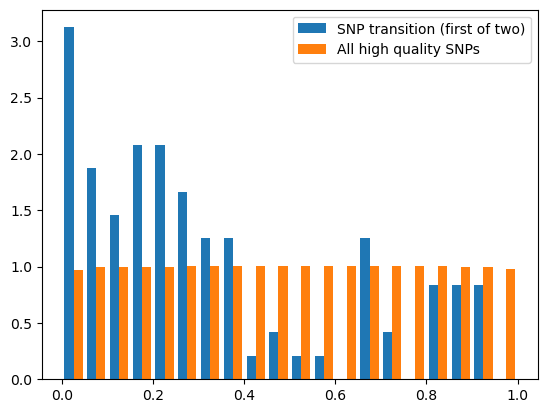

In [49]:
plt.hist(
    [
        (cand_snps_df[nzi]
            .select((pl.col("start") / pl.col("read_length1")).alias("relative_start"))
        )["relative_start"],
        (high_conf_snps_df
            .filter("is_high_quality_snp")
            .select((pl.col("start") / pl.col("read_length1")).alias("relative_start"))
        )["relative_start"],
    ],
    bins=np.linspace(0,1,21),
    density=True,
);

plt.legend(["SNP transition (first of two)", "All high quality SNPs"]);

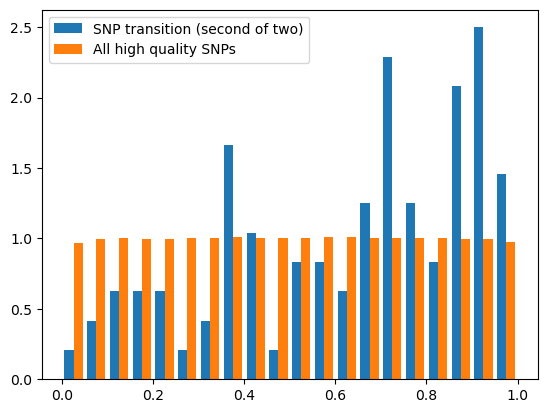

In [50]:
plt.hist(
    [
        (cand_snps_df[nzi+1]
            .select((pl.col("end") / pl.col("read_length1")).alias("relative_end"))
        )["relative_end"],
        (high_conf_snps_df
            .filter("is_high_quality_snp")
            .select((pl.col("end") / pl.col("read_length1")).alias("relative_end"))
        )["relative_end"],
    ],
    bins=np.linspace(0,1,21),
    density=True,
);

plt.legend(["SNP transition (second of two)", "All high quality SNPs"]);

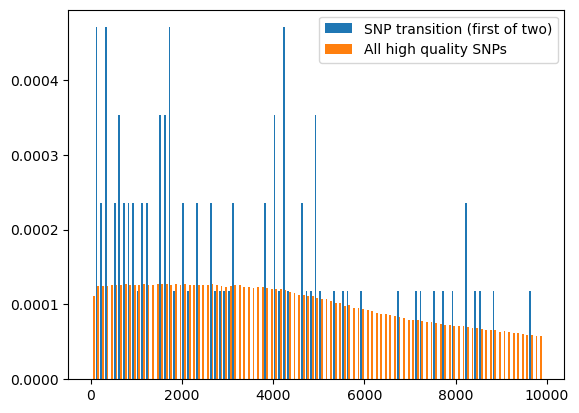

In [51]:
plt.hist(
    [
        cand_snps_df[nzi]["start"],
        high_conf_snps_df.filter("is_high_quality_snp")["start"],
    ],
    bins=np.arange(0, 10000, 100), #np.linspace(0,1,21),
    density=True,
);

plt.legend(["SNP transition (first of two)", "All high quality SNPs"]);

# Check phasing blocks?

In [52]:
backbam1 = pysam.AlignmentFile(
    "/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/PD50489e/PD50489e.hap1.minimap2_back_contigs.sorted.bam",
)

backbam2 = pysam.AlignmentFile(
    "/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/PD50489e/PD50489e.hap2.minimap2_back_contigs.sorted.bam",
)

In [53]:
contigs = set()
contig_to_cigar_stats1 = {}
contig_to_cigar_stats2 = {}

for aln1 in tqdm.tqdm(backbam1.fetch()):
    if not aln1.is_secondary or aln1.is_supplementary:
        contigs.add(aln1.query_name)
        contig_to_cigar_stats1[aln1.query_name] = aln1.query_alignment_length - aln1.get_cigar_stats()[0][0]  
        
for aln2 in tqdm.tqdm(backbam2.fetch()):
    if not aln2.is_secondary or aln2.is_supplementary:
        contigs.add(aln2.query_name)
        contig_to_cigar_stats2[aln2.query_name] = aln2.query_alignment_length - aln2.get_cigar_stats()[0][0] 


14286it [00:13, 1097.85it/s]
20344it [00:13, 1483.13it/s]


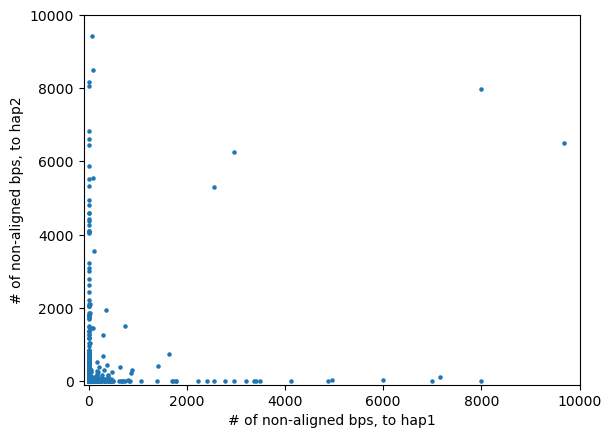

In [54]:
plt.scatter(
    [contig_to_cigar_stats1.get(contig, -1) for contig in contigs],
    [contig_to_cigar_stats2.get(contig, -1) for contig in contigs],
    s=5,
);
plt.xlabel("# of non-aligned bps, to hap1");
plt.ylabel("# of non-aligned bps, to hap2");
plt.xlim(-100,10000);
plt.ylim(-100,10000);

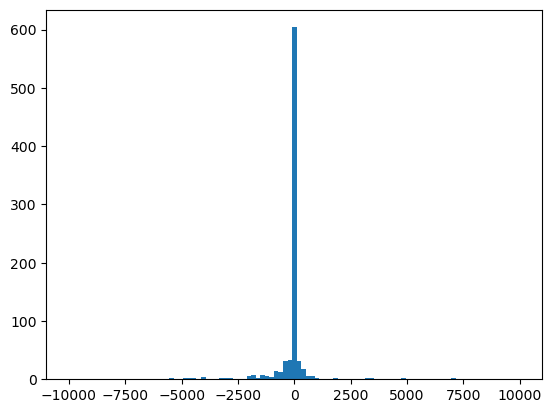

In [55]:
plt.hist(
    [contig_to_cigar_stats1.get(contig, -1)-contig_to_cigar_stats2.get(contig, -1) for contig in contigs],
    bins=np.linspace(-1e4,1e4,100),
);

In [56]:
xxx = [(1-contig_to_cigar_stats1.get(contig, -1), 1-contig_to_cigar_stats2.get(contig, -1)) for contig in contigs]


In [57]:
print(len(xxx))
print(len([x for x in xxx if x[0] == 0 or x[1] == 0]))
print(len([x for x in xxx if x[0] == 0 and x[1] == 0]))

851
70
1


In [58]:
(93)/851

0.10928319623971798

# Do reads overlap gaps in scaffolding?

In [59]:
denovo_hap1_fasta_file = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/05.ragtag/03.haplotype_specific_scaffolds") \
            / f"{focal_sample_id}" / "haplotype_1" / "ragtag.scaffold.fasta"
denovo_hap2_fasta_file = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/05.ragtag/03.haplotype_specific_scaffolds") \
            / f"{focal_sample_id}" / "haplotype_2" / "ragtag.scaffold.fasta"

denovo_hap1_alignment_bam_file = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / f"{focal_sample_id}.hap1.minimap2.sorted.primary_alignments.bam"
denovo_hap2_alignment_bam_file = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / f"{focal_sample_id}.hap2.minimap2.sorted.primary_alignments.bam"

denovo_hap1_bam = pysam.AlignmentFile(denovo_hap1_alignment_bam_file)
denovo_hap2_bam = pysam.AlignmentFile(denovo_hap2_alignment_bam_file)


In [60]:
focal_sample_id = "PD50489e"
t2t_chrom = "chr2"
denovo_chrom = t2t_chrom + "_RagTag"

from Bio import SeqIO
for record1 in SeqIO.parse(denovo_hap1_fasta_file, format="fasta"):
    if denovo_chrom in record1.id:
        break
        
for record2 in SeqIO.parse(denovo_hap2_fasta_file, format="fasta"):
    if denovo_chrom in record2.id:
        break        

In [61]:
test_read = "m64094e_220715_151527/83298762/ccs"

In [62]:
%%time
for denovo_hap1_read_aln in denovo_hap1_bam.fetch(denovo_chrom, multiple_iterators=True):
    if denovo_hap1_read_aln.query_name == test_read:
        print("found it")
        break

for denovo_hap2_read_aln in denovo_hap2_bam.fetch(denovo_chrom, multiple_iterators=True):
    if denovo_hap2_read_aln.query_name == test_read:
        print("found it")
        break
        

found it
found it
CPU times: user 12.4 s, sys: 640 ms, total: 13.1 s
Wall time: 13.1 s


In [63]:
'N' in record1.seq[denovo_hap1_read_aln.reference_start:denovo_hap1_read_aln.reference_end]

False

In [64]:
denovo_hap1_read_aln.reference_length

10468

In [65]:
record1.seq[denovo_hap1_read_aln.reference_start:denovo_hap1_read_aln.reference_end].find('N')

-1

In [66]:
'N' in record2.seq[denovo_hap2_read_aln.reference_start:denovo_hap2_read_aln.reference_end]

False

In [67]:
for denovo_hap1_read_aln in denovo_hap1_bam.fetch(denovo_chrom, multiple_iterators=True):
    ref = record1.seq[denovo_hap1_read_aln.reference_start:denovo_hap1_read_aln.reference_end]
    if 'N' in ref:
        print("found something", denovo_hap1_read_aln.query_name, ref.find('N'), len(ref))
        break

found something m64094e_220717_002414/102762061/ccs 18356 21085


# Classify SNPs - test code

In [68]:
%%time
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]


all_res = []

def dome(focal_sample_id, denovo_chrom):
    candidates_df = pl.read_parquet(
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_0.95.candidate_reads.parquet"
    )

    snps_df = pl.read_parquet(
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_0.95.snps.parquet"
    )
    
    res_df = diagnostics.classify_all_reads(
        snps_df,
        candidates_df,
    )
    
    res_df = res_df.with_columns(pl.lit(denovo_chrom).alias("chrom"), pl.lit(focal_sample_id).alias("sample_id"))
    return res_df
    
all_res = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(dome)(focal_sample_id, chrom + "_RagTag") \
        for chrom in aut_chrom_names \
        for focal_sample_id in sample_ids
)
        
all_res_df = pl.concat(all_res)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

CPU times: user 707 ms, sys: 1.06 s, total: 1.77 s
Wall time: 3min 3s


[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:  3.1min finished


In [69]:
all_res_df["class"].value_counts()

class,counts
str,u32
"""ambiguous""",4075
"""CNCO""",565
"""GC""",1650
"""CO""",6945


In [70]:
all_res_df.filter(~pl.col("has_common_transition"))["class"].value_counts()

class,counts
str,u32
"""CO""",3183
"""GC""",829
"""CNCO""",261
"""ambiguous""",1530


In [71]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
    #display(res_df)
    #display(all_res_df.filter(~pl.col("has_common_transition")))
    display(all_res_df.filter(~pl.col("has_common_transition")).filter(pl.col("class") == "CNCO"))
    #display(res_df.filter(pl.col("read_name") == "m64174e_220620_110709/58458841/ccs"))

read_name,n_transitions,class,has_common_transition,chrom,sample_id
str,i64,str,bool,str,str
"""m64094e_220917_231317/13764395/ccs""",5,"""CNCO""",false,"""chr1_RagTag""","""PD50477f"""
"""m64230e_220906_003948/134744140/ccs""",4,"""CNCO""",false,"""chr1_RagTag""","""PD50477f"""
"""m64178e_220829_002441/6554636/ccs""",7,"""CNCO""",false,"""chr1_RagTag""","""PD50477f"""
"""m64222e_220804_013319/31917386/ccs""",7,"""CNCO""",false,"""chr1_RagTag""","""PD50519d"""
"""m64221e_220814_084225/89721435/ccs""",7,"""CNCO""",false,"""chr1_RagTag""","""PD50519d"""
"""m64221e_220811_133409/56033730/ccs""",4,"""CNCO""",false,"""chr1_RagTag""","""PD50519d"""
"""m64221e_220811_133409/5636632/ccs""",3,"""CNCO""",false,"""chr1_RagTag""","""PD50519d"""
"""m64222e_220804_013319/119603965/ccs""",4,"""CNCO""",false,"""chr1_RagTag""","""PD50519d"""
"""m64016e_220903_004635/42666207/ccs""",3,"""CNCO""",false,"""chr1_RagTag""","""PD50523b"""
